In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from os import listdir
from os.path import join,isfile
import random
import pandas as pd
from scipy import stats

In [2]:
splitData = 0.1
myPath = r'C:\Users\Ashu\Desktop\Git\papers\eeg_csv'
onlyfile = [join(myPath,f) for f in listdir(myPath) if isfile(join(myPath,f))]
random.shuffle(onlyfile)
splitData = int(splitData*len(onlyfile))
trainPath,testPath = onlyfile[splitData:],onlyfile[:splitData]

In [3]:
train_ds = tf.data.Dataset.list_files(trainPath)
test_ds = tf.data.Dataset.list_files(testPath)

In [4]:
trainData = pd.read_csv(trainPath[0])#pd.concat((pd.read_csv(filePath) for filePath in trainPath),ignore_index=True)
testData = pd.read_csv(testPath[0])#pd.concat((pd.read_csv(filePath) for filePath in testPath),ignore_index=True)

In [25]:
trainData = trainData[['EEG Fp1','Action']]
testData = testData[['EEG Fp1','Action']]

In [7]:
from tensorflow import keras
from keras import Input
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [26]:
#https://github.com/ni79ls/har-keras-cnn
def create_segments_and_labels(df, time_steps, step, label_name):
    # x, y, z acceleration as features
    N_FEATURES = 1
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['EEG Fp1'].values[i: i + time_steps]
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

In [27]:
time_window_size =5000
xTrain,yTrain = create_segments_and_labels(trainData,time_window_size,1,'Action')
xTest,yTest = create_segments_and_labels(testData,time_window_size,1,'Action')

In [39]:
time_window_size =5000
model = Sequential(name='EEG')
# model.add(Input(shape=(time_window_size,1),name='Input'))
model.add(Conv1D(filters=16,kernel_size=5,activation='relu',input_shape = (5000,1),name='Layer1'))
model.add(Conv1D(filters=32,kernel_size=5,activation='relu',name='Layer2'))
model.add(MaxPooling1D(pool_size=2,strides=2,name='Maxpool1d'))
model.add(Flatten(name='Flatten'))
model.add(Dense(1,activation='sigmoid',name='Output'))
model.summary()

Model: "EEG"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer1 (Conv1D)              (None, 4996, 16)          96        
_________________________________________________________________
Layer2 (Conv1D)              (None, 4992, 32)          2592      
_________________________________________________________________
Maxpool1d (MaxPooling1D)     (None, 2496, 32)          0         
_________________________________________________________________
Flatten (Flatten)            (None, 79872)             0         
_________________________________________________________________
Output (Dense)               (None, 1)                 79873     
Total params: 82,561
Trainable params: 82,561
Non-trainable params: 0
_________________________________________________________________


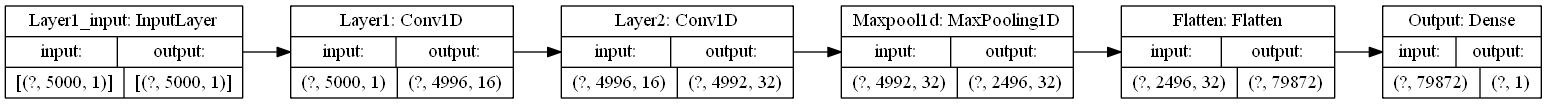

In [40]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [ ]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [41]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])
history = model.fit(xTrain,yTrain,
                    batch_size=20,
                    epochs=1,verbose=1,
                    validation_data=(xTest,yTest)
                   )

4300/4300 [==============================] - 362s 84ms/step - loss: 9.9326e-04 - accuracy: 0.9999 - val_loss: 21.8563 - val_accuracy: 0.0000e+00


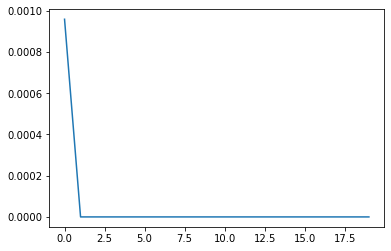

In [18]:
plt.plot(history.history['loss'])
plt.show()